In [141]:
import pandas as pd
import seaborn as sns
import json
import numpy as np
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  train_test_split, cross_val_score, GridSearchCV
# from sklearn import dummy
from sklearn import preprocessing
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import collections

* fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
* channelGrouping - The channel via which the user came to the Store.
* date - The date on which the user visited the Store.
* device - The specifications for the device used to access the Store.
* geoNetwork - This section contains information about the geography of the user.
* sessionId - A unique identifier for this visit to the store.
* socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
* totals - This section contains aggregate values across the session.
* trafficSource - This section contains information about the Traffic Source from which the session originated.
* visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is * only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
* visitNumber - The session number for this user. If this is the first session, then this is set to 1.
* visitStartTime - The timestamp (expressed as POSIX time).

In [35]:
def read_csv():
    
    df_submit =  pd.read_csv('./sample_submission.csv',dtype = {'fullVisitorId' : str})
    df_test = pd.read_csv('./test.csv',dtype = {'fullVisitorId' : str})
    df_train = pd.read_csv('./train.csv',dtype = {'fullVisitorId' : str})
    
    return df_submit, df_test, df_train

In [36]:
df_submit, df_test, df_train = read_csv()

In [37]:
def json_parser (df):
    col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df_device = pd.DataFrame([json.loads(j) for j in df['device']])
    df_geoNetwork = pd.DataFrame([json.loads(j) for j in df['geoNetwork']])
    df_totals = pd.DataFrame([json.loads(j) for j in df['totals']])
    df_trafficSource = pd.DataFrame([json.loads(j) for j in df['trafficSource']])
    df_trafficSource = df_trafficSource.drop('adwordsClickInfo', axis = 1)
    df = df.join([df_device, df_geoNetwork, df_totals, df_trafficSource])
    df = df.drop(col, axis = 1)                           
    return df

In [38]:
df_test = json_parser(df_test)
df_train = json_parser(df_train)

In [39]:
set_test_col = set(df_test.columns)

set_train_col  = set(df_train.columns)

set_train_col - set_test_col 

{'campaignCode', 'transactionRevenue'}

In [40]:
len(set_train_col.intersection(set_test_col))

47

In [41]:
df_train.isnull().apply(pd.Series.value_counts)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source
False,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,450630,903653.0,703060,903553,11515,903653.0,10946,903653.0,1,274005,400724,903653.0,330941,903653.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,453023,NaN,200593,100,892138,NaN,892707,NaN,903652,629648,502929,NaN,572712,NaN


In [49]:
df_test.isnull().apply(pd.Series.value_counts)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,visits,adContent,campaign,isTrueDirect,keyword,medium,referralPath,source
False,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,804684.0,420948,804684.0,604370,804545,804684.0,53791,804684.0,260513,413652,804684.0,235323,804684.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,383736,NaN,200314,139,NaN,750893,NaN,544171,391032,NaN,569361,NaN


In [44]:
def date_parser(df):
    df['date'] = pd.to_datetime(df['date'].astype(str))
    df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit = 's')
    return df

In [47]:
df_train = date_parser(df_train)
df_test = date_parser(df_test)

In [69]:
def add_time_features(df):
    df['dayofweek'] = df['visitStartTime'].dt.dayofweek
    df['hour'] = df['visitStartTime'].dt.hour
    df['month'] = df['visitStartTime'].dt.month
    df[['dayofweek','hour','month']] = df[['dayofweek','hour','month']].apply(lambda x : x.astype('category') )
    return df

In [70]:
df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

In [72]:
df_train.dtypes

channelGrouping                      object
date                         datetime64[ns]
fullVisitorId                        object
sessionId                            object
socialEngagementType                 object
visitId                               int64
visitNumber                           int64
visitStartTime               datetime64[ns]
browser                              object
browserSize                          object
browserVersion                       object
deviceCategory                       object
flashVersion                         object
isMobile                               bool
language                             object
mobileDeviceBranding                 object
mobileDeviceInfo                     object
mobileDeviceMarketingName            object
mobileDeviceModel                    object
mobileInputSelector                  object
operatingSystem                      object
operatingSystemVersion               object
screenColors                    

In [105]:
def heat_map (df):
    plt.figure(dpi=100)
    (sns.heatmap( df.groupby([df.date.dt.month,
                             df.date.dt.dayofweek])['visitStartTime']
                 .count()
                 .unstack(),
                 cmap='YlGnBu',
                 annot=True, 
                 fmt="d",
                ))
    plt.xlabel('dayofweek')
    plt.ylabel('month')

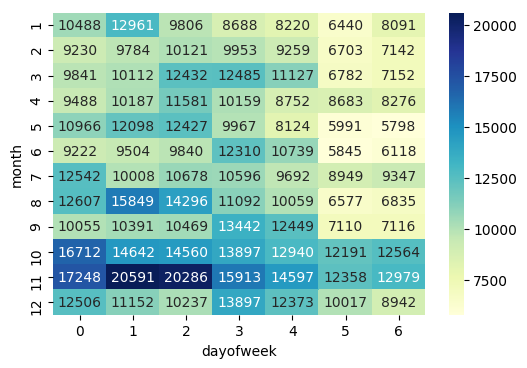

In [106]:
heat_map(df_train)

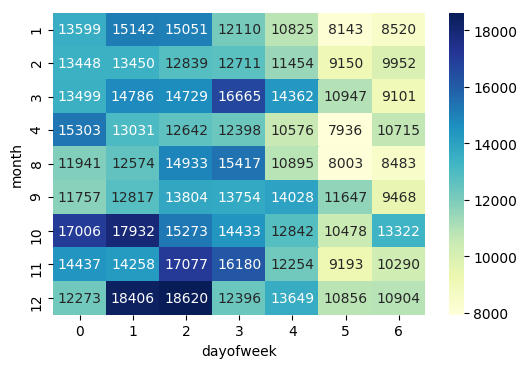

In [107]:
heat_map(df_test)

[source : Understanding Google Analytics Channels](https://megalytic.com/blog/understanding-google-analytics-channels)
* Direct:
In general, indicates visits where users navigated directly to the URL or the source of the visit is unknown. See: Understanding Direct Traffic in Google Analytics
Determined by a source of direct and medium of (not set) or (none)
* Organic Search:
Indicates visits from organic (unpaid) search results
Determined by medium of organic
* Social:
Indicates visits from social networks (Facebook, Twitter, etc.)
Determined when Social Source Referral matches “yes;” Google Analytics also places these in the referral “bucket” matching a list of known social sources or when medium matches social, social-network, social-media, sm, social network, or social media
* Email:
Indicates traffic from links clicked in email messages, whether mass email marketing or individual messages
Determined by medium of email
* Affiliates:
Indicates traffic from affiliate marketing efforts
Determined by medium of affiliate
* Referral:
Indicates traffic where users clicked a link from another site, excluding major search engines
Determined by medium of referral
* Paid Search:
Indicates traffic from PPC campaigns run in search results
Determined by medium of cpc, ppc, or paidsearch; also, excludes traffic in “Content” bucket of ad networks
* Other Advertising:
Indicates traffic from online advertising outside of search and display, such as cost-per-view video advertising
Determined by medium of cpv, cpa, or cpp
* Display:
Indicates traffic from display advertising, such as Google AdWords remarketing campaigns
Determined by medium of display, cpm, or banner, or in “Content” bucket of ad networks (indicating Google Display Network)

In [102]:
df_test.channelGrouping.value_counts()/df_train.channelGrouping.value_counts()

(Other)           0.141667
Affiliates        1.006645
Direct            0.909681
Display           7.189556
Organic Search    0.936684
Paid Search       0.801587
Referral          1.015557
Social            0.569855
Name: channelGrouping, dtype: float64

In [109]:
df_train.dtypes
['browser', 'deviceCategory', 'operatingSystem','subContinent' ]

channelGrouping                      object
date                         datetime64[ns]
fullVisitorId                        object
sessionId                            object
socialEngagementType                 object
visitId                               int64
visitNumber                           int64
visitStartTime               datetime64[ns]
browser                              object
browserSize                          object
browserVersion                       object
deviceCategory                       object
flashVersion                         object
isMobile                               bool
language                             object
mobileDeviceBranding                 object
mobileDeviceInfo                     object
mobileDeviceMarketingName            object
mobileDeviceModel                    object
mobileInputSelector                  object
operatingSystem                      object
operatingSystemVersion               object
screenColors                    

In [112]:
s =  df_train.loc[:,['browser', 'deviceCategory', 'operatingSystem','subContinent']]

In [136]:
list_c = []
for i in range(len(s.columns)):
    list_c.append([s.iloc[:,i]])

In [ ]:
def compare_data_set(df1,df2)
    cols = ['browser', 'deviceCategory', 'operatingSystem','subContinent']
    df1 = df1.loc[:, cols]
    df2 = df2.loc[:, cols]
    df1['browser'].value_counts()/df2['browser'].value_counts()
    

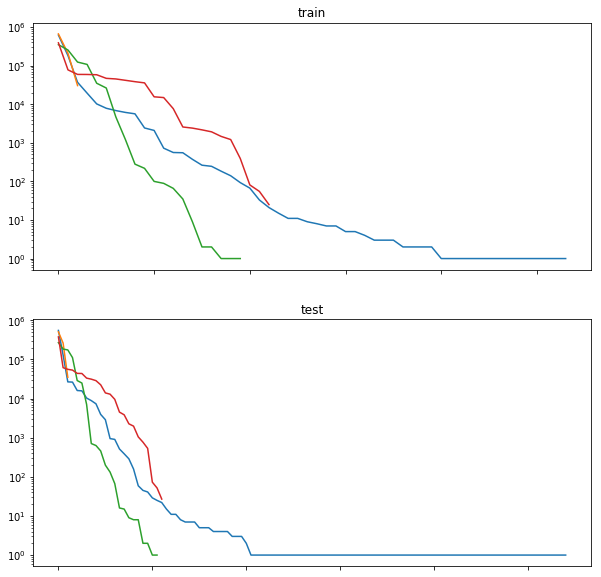

In [169]:
cols = ['browser', 'deviceCategory', 'operatingSystem','subContinent']
fig, ax =plt.subplots(2,1)
[df_train[col].value_counts().plot(figsize = (10,10), logy = True, ax = ax[0], title = 'train') for col in cols]
[df_test[col].value_counts().plot(figsize = (10,10), logy = True, ax = ax[1],title = 'test') for col in cols]

* totals.bounces	INTEGER	Total bounces (for convenience). For a bounced session, the value is 1, otherwise it is null.
* totals.hits	INTEGER	Total number of hits within the session.
* totals.newVisits	INTEGER	Total number of new users in session (for convenience). If this is the first visit, this value is 1, otherwise it is null.
* totals.pageviews	INTEGER	Total number of pageviews within the session.
* totals.totalTransactionRevenue	INTEGER	Total transaction revenue, expressed as the value passed to Analytics multiplied by 10^6 (e.g., 2.40 would be given as 2400000).
* totals.visits	INTEGER	The number of sessions (for convenience). This value is 1 for sessions with interaction events. The value is null if there are no interaction events in the session.

[BigQuery Export schema](https://support.google.com/analytics/answer/3437719?hl=en)

* [Google Analytics: Desktop vs. Mobile vs. Tablet Metrics](https://www.hallaminternet.com/google-analytics-desktop-vs-mobile-vs-tablet-metrics/)
* [Sessions by Device Type](https://www.klipfolio.com/resources/kpi-examples/digital-marketing/sessions-by-device-type)


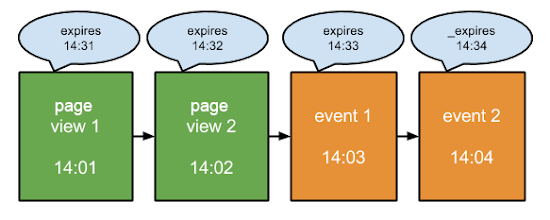

In [ ]:
df_trafficSource = pd.DataFrame([json.loads(i) for i in df_train.trafficSource])

In [ ]:
df_adwordsClickInfo = pd.DataFrame([i for i in df_trafficSource['adwordsClickInfo']])
# .apply(pd.Series.value_counts).sort_values(by= 'medium',ascending = False)

In [ ]:
df_adwordsClickInfo.iloc[:,0:6].count()

In [ ]:
df_trafficSource['campaign'].value_counts()

In [ ]:
df_trafficSource = df_trafficSource.join(df_adwordsClickInfo)

In [ ]:
df_trafficSource = df_trafficSource.drop('adwordsClickInfo',axis=1)

* Source: Every referral to a web site has an origin, or source. Possible sources include: “google” (the name of a search engine), “facebook.com” (the name of a referring site), “spring_newsletter” (the name of one of your newsletters), and “direct” (users that typed your URL directly into their browser, or who had bookmarked your site).

* Medium: Every referral to a website also has a medium. Possible medium include: “organic” (unpaid search), “cpc” (cost per click, i.e. paid search), “referral” (referral), “email” (the name of a custom medium you have created), “none” (direct traffic has a medium of “none”).

* Keyword: When SSL search is employed, Keyword will have the value (not provided).

* Campaign is the name of the referring Google Ads campaign or a custom campaign that you have created.

* Content identifies a specific link or content item in a custom campaign. For example, if you have two call-to-action links within the same email message, you can use different Content values to differentiate them so that you can tell which version is most effective.

* [Traffic source dimensions](https://support.google.com/analytics/answer/1033173?hl=en)
* [Direct-traffic](https://moz.com/blog/guide-to-direct-traffic-google-analytics)

In [ ]:
df_train = df_train.drop(['device','geoNetwork','totals','trafficSource'], axis = 1)

In [ ]:
df_all_parsed = df_train.join([df_device_, df_geo_, df_total, df_trafficSource])

In [ ]:
df_all_parsed = df_all_parsed.fillna(0)

In [ ]:
df_all_parsed.columns

In [ ]:
df_dummies = pd.get_dummies(drop_first = True, data = df_all_parsed[['channelGrouping','browser',
       'operatingSystem', 'country',  'medium', 'source','subContinent']])

In [ ]:
df_all_parsed = (df_all_parsed.drop(['channelGrouping', 'browser','operatingSystem', 'country',  'medium', 
                                     'source','metro', 'region', 'networkDomain', 'adContent','continent'], axis=1))

In [ ]:
df_all_parsed.join(df_dummies)

In [ ]:
df_all_parsed.iloc[:,10:30]['hits'].astype('int').describe()